# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import tensorflow as tf
import random
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD  # Add this import
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from IPython import display 

# Pernament random

In [2]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

# Function

In [3]:
def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data

def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)
    
    #train
    x_train, y_train = load_data(csv_train)
    
    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n", 
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"], 
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n", 
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np
    
    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for
    
    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if
    
    if is_show == True: 
        plt.show()
        return None
    return fig
# visualize_logs

# Load data

In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

# Load data

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_model(input_nodes=2, hidden_nodes=20, hidden_layers=1, output_nodes=1, 
                hidden_activation='relu', output_activation='linear'):
    """
    Hàm xây dựng mô hình baseline với khả năng thay đổi số hidden layers và hidden nodes.

    Args:
        input_nodes (int): Số lượng input nodes (mặc định là 2).
        hidden_nodes (int): Số lượng hidden nodes trong mỗi hidden layer (mặc định là 20).
        hidden_layers (int): Số lượng hidden layers (mặc định là 1).
        output_nodes (int): Số lượng output nodes (mặc định là 1).
        hidden_activation (str): Hàm kích hoạt của hidden layers (mặc định là 'relu').
        output_activation (str): Hàm kích hoạt của output layer (mặc định là 'linear').

    Returns:
        model (Model): Mô hình Keras với cấu trúc yêu cầu.
    """
    # Input layer
    inp = Input(shape=(input_nodes,), name='Input')
    x = inp

    # Hidden layers
    for i in range(hidden_layers):
        x = Dense(units=hidden_nodes, activation=hidden_activation, name=f'HiddenLayer_{i+1}')(x)

    # Output layer
    output_label = Dense(units=output_nodes, activation=output_activation, name='Output')(x)

    # Model
    model = Model(inputs=inp, outputs=output_label)
    model.summary()
    return model

# Ví dụ: Xây dựng mô hình baseline với 1 hidden layer, 20 hidden nodes, 2 input nodes, 1 output node
baseline_model = build_model(input_nodes=2, hidden_nodes=20, hidden_layers=1, output_nodes=1,
                             hidden_activation='relu', output_activation='linear')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

# Experiment Sample

## Train data

In [6]:
x_expSam_train, y_expSam_train = [], []
x_expSam_valid, y_expSam_valid = x_valid, y_valid
print("Train: ")
for size in range(200, 4001, 200):
    x_expSam_train.append(x_train[:size])
    y_expSam_train.append(y_train[:size])
    print(f"+ Size: {size} {x_expSam_train[-1].shape} {y_expSam_train[-1].shape}")
# for
print(f"Valid: {x_expSam_valid.shape} {y_expSam_valid.shape}")

Train: 
+ Size: 200 (200, 2) (200,)
+ Size: 400 (400, 2) (400,)
+ Size: 600 (600, 2) (600,)
+ Size: 800 (800, 2) (800,)
+ Size: 1000 (1000, 2) (1000,)
+ Size: 1200 (1200, 2) (1200,)
+ Size: 1400 (1400, 2) (1400,)
+ Size: 1600 (1600, 2) (1600,)
+ Size: 1800 (1800, 2) (1800,)
+ Size: 2000 (2000, 2) (2000,)
+ Size: 2200 (2200, 2) (2200,)
+ Size: 2400 (2400, 2) (2400,)
+ Size: 2600 (2600, 2) (2600,)
+ Size: 2800 (2800, 2) (2800,)
+ Size: 3000 (3000, 2) (3000,)
+ Size: 3200 (3200, 2) (3200,)
+ Size: 3400 (3400, 2) (3400,)
+ Size: 3600 (3600, 2) (3600,)
+ Size: 3800 (3800, 2) (3800,)
+ Size: 4000 (4000, 2) (4000,)
Valid: (100, 2) (100,)


## Model

In [7]:
expSam_model = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

## Get Epoch

In [8]:
import json

# Load best_epoch from JSON file
with open('best_epoch.json', 'r') as f:
    data = json.load(f)
    best_epoch = data["best_epoch"]

print(f"Loaded best_epoch: {best_epoch}")


Loaded best_epoch: 312


# Training

In [9]:
def train_model(train_id, x_local_train, y_local_train,
                x_local_valid, y_local_valid, nb_epochs = best_epoch):

    K.clear_session()
    expSam_model = build_model()

    # OPTIMIZATION
    expSam_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_02/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath=os.path.join(save_dir, template_name),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,  # only save weights if set to True
    mode='auto',  # min, max, auto
    save_freq='epoch'  # Replaces 'period', saves every epoch
                                              )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                           "style": "median"},
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False,
                             save_path = os.path.join(f"./data/model/train_02/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = expSam_model.fit(x_local_train, y_local_train,
                        validation_data=(x_local_valid, y_local_valid),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = callbacks,
                        verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history
# train_model

Train id: 0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

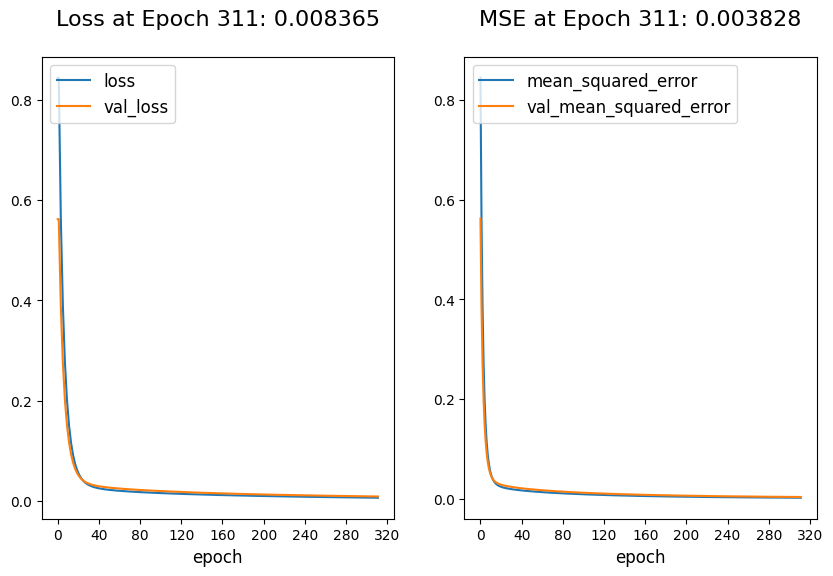

> training time is 1.6489 minutes
Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

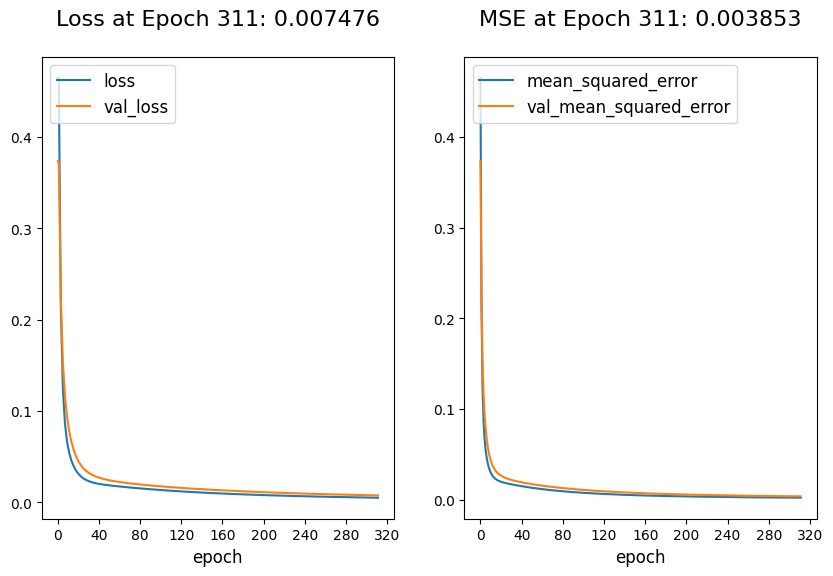

> training time is 2.0245 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

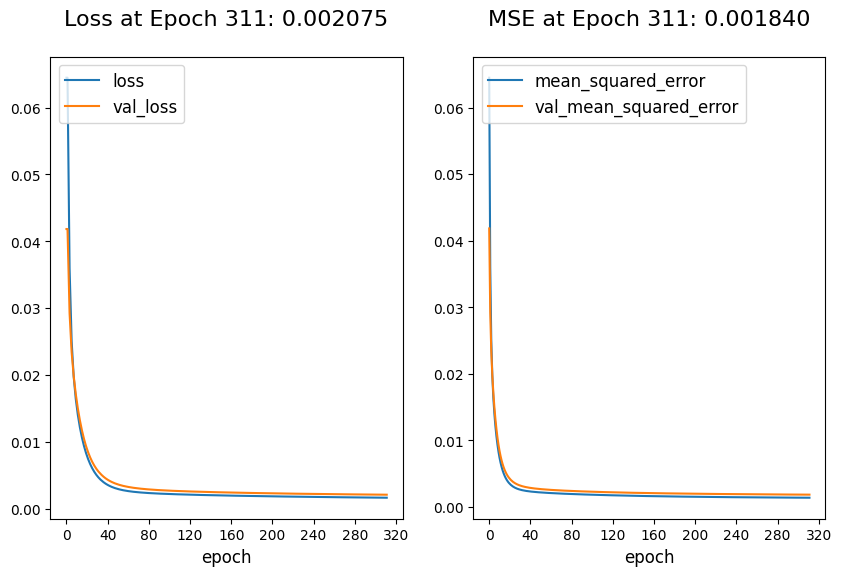

> training time is 1.8550 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

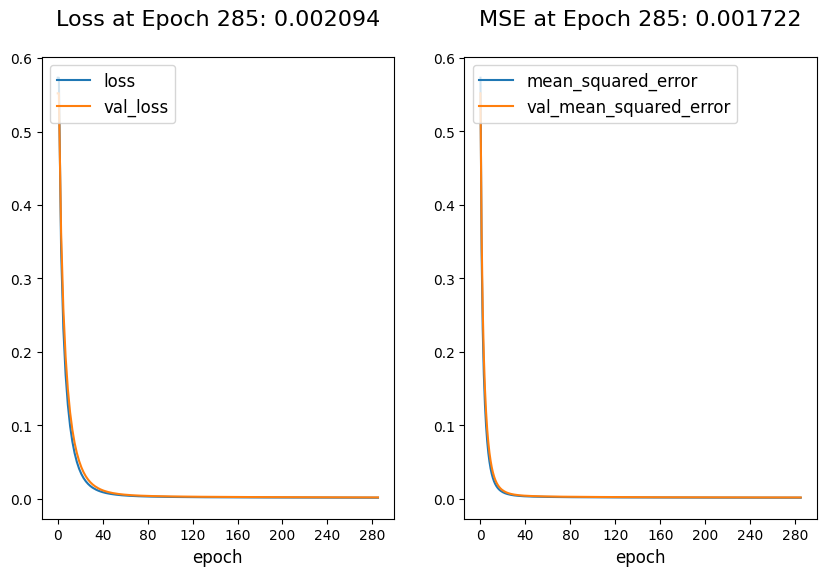

In [ ]:
history = []
for i in range(len(x_expSam_train)):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_expSam_train[i], y_expSam_train[i], x_expSam_valid, y_expSam_valid, nb_epochs = best_epoch)
    history.append(temp_history)
# for